In [54]:
import pandas as pd
import glob
import os

# Path to your training data
DATA_PATH = "/Users/jrg/Library/CloudStorage/OneDrive-HealthStrategy/Documents/code/ev/Project_K/data/training/"

# Load a small sample to check the schema quickly
df_sample = pd.read_parquet(DATA_PATH).head(5)

print("Columns actually found in your Parquet files:")
print(df_sample.columns.tolist())

Columns actually found in your Parquet files:
['time_idx', 'series_ticker', 'status', 'ticker', 'timestamp', 'bid', 'ask', 'spread', 'volume', 'bid_count', 'ask_count', 'obi', 'spread_velocity', 'momentum_5', 'momentum_10', 'momentum_20', 'date', 'category']


In [55]:
# Load the absolute newest file
latest_file = max(glob.glob("data/training/**/*.parquet", recursive=True), key=os.path.getmtime)
df = pd.read_parquet(latest_file)
print("GOLD CHECK:", "obi" in df.columns and "momentum_5" in df.columns)
print("Columns found:", df.columns.tolist())

GOLD CHECK: True
Columns found: ['time_idx', 'series_ticker', 'status', 'ticker', 'timestamp', 'bid', 'ask', 'spread', 'volume', 'bid_count', 'ask_count', 'obi', 'spread_velocity', 'momentum_5', 'momentum_10', 'momentum_20']


In [56]:
df.head(10)

,time_idx,series_ticker,status,ticker,timestamp,bid,ask,spread,volume,bid_count,ask_count,obi,spread_velocity,momentum_5,momentum_10,momentum_20
0,536,KXNFLSPREAD,active,KXNFLSPREAD-26FEB08SEANE-SEA4,1970-01-01 00:00:01.769955820,51,52,1,1276254,0,0,0.0,0,0.0,0.0,0.0
1,1941,KXPGATOUR,active,KXPGATOUR-FAIO26-JDAH,1970-01-01 00:00:01.769955758,2,4,2,881258,0,0,0.0,0,0.0,0.0,0.0
2,1941,KXPGATOUR,active,KXPGATOUR-FAIO26-WKIM,1970-01-01 00:00:01.769955758,1,2,1,777795,0,0,0.0,0,0.0,0.0,0.0
3,508,KXNFLSPREAD,active,KXNFLSPREAD-26FEB08SEANE-SEA5,1970-01-01 00:00:01.769955820,47,49,2,606157,0,0,0.0,0,0.0,0.0,0.0
4,424,KXNFLSPREAD,active,KXNFLSPREAD-26FEB08SEANE-SEA3,1970-01-01 00:00:01.769955821,54,55,1,562934,0,0,0.0,0,0.0,0.0,0.0
5,424,KXNFLSPREAD,active,KXNFLSPREAD-26FEB08SEANE-SEA6,1970-01-01 00:00:01.769955821,43,45,2,368720,0,0,0.0,0,0.0,0.0,0.0
6,1156,KXDPWORLDTOUR,active,KXDPWORLDTOUR-BAC26-FSCH,1970-01-01 00:00:01.769955755,99,100,1,367873,0,0,0.0,0,0.0,0.0,0.0
7,368,KXNFLTOTAL,active,KXNFLTOTAL-26FEB08SEANE-45,1970-01-01 00:00:01.769955820,49,50,1,246372,0,0,0.0,0,0.0,0.0,0.0
8,2619,KXNOEMOUT,active,KXNOEMOUT-26MAR01,1970-01-01 00:00:01.769955721,16,17,1,220787,0,0,0.0,0,0.0,0.0,0.0
9,284,KXNFLANYTD,active,KXNFLANYTD-26FEB08SEANE-SEASDARNOLD14,1970-01-01 00:00:01.769955820,9,10,1,159025,0,0,0.0,0,0.0,0.0,0.0


In [57]:
# Load all data collected overnight
df = pd.read_parquet("data/training/")

# Convert timestamp for chronological sorting
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [58]:
# Identify potential trades based on your strategy's threshold
# (Example: Momentum > 5 cents or OBI imbalance)
signals = df[df['momentum_5'].abs() > 5].copy()

print(f"Total signals detected: {len(signals)}")
signals[['timestamp', 'ticker', 'category', 'bid', 'momentum_5', 'obi']].head()

Total signals detected: 2655


,timestamp,ticker,category,bid,momentum_5,obi
352933,1970-01-01 00:00:01.769924639,KXNCAAMBTOTAL-26JAN31SMCGONZ-140,MISC,13,-57.0,0.0
352844,1970-01-01 00:00:01.769924639,KXNCAAMBTOTAL-26JAN31SMCGONZ-143,MISC,2,-38.0,0.0
352930,1970-01-01 00:00:01.769924639,KXNCAAMBTOTAL-26JAN31SMCGONZ-149,MISC,1,-9.5,0.0
352927,1970-01-01 00:00:01.769924639,KXNCAAMBSPREAD-26JAN31SMCGONZ-GONZ6,MISC,86,19.5,0.0
352928,1970-01-01 00:00:01.769924639,KXNCAAMBTOTAL-26JAN31SMCGONZ-143,MISC,2,-38.0,0.0


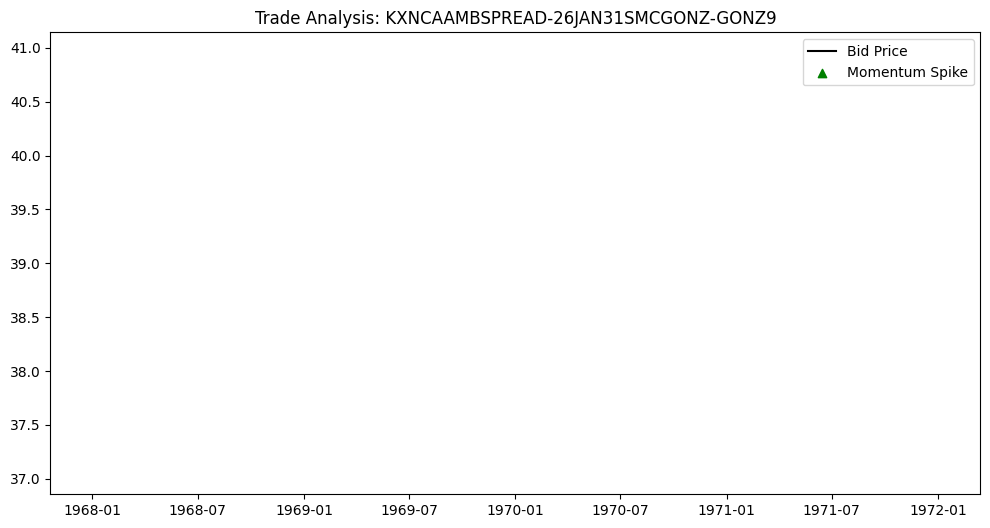

In [66]:
import matplotlib.pyplot as plt

# Fix the timestamp unit (M4 records in seconds, Pandas expects nanoseconds)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Pick a ticker that actually exists in your "Winners" or "Toxic" list
target_ticker = "KXNCAAMBSPREAD-26JAN31SMCGONZ-GONZ9" # Or pick one from the audit printout

ticker_df = df[df['ticker'] == target_ticker]

if not ticker_df.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_df['timestamp'], ticker_df['bid'], label='Bid Price', color='black')
    
    # Overlay momentum signals
    # We use momentum_5 because OBI is currently dead
    buys = ticker_df[ticker_df['momentum_5'] > 5]
    plt.scatter(buys['timestamp'], buys['bid'], color='green', marker='^', label='Momentum Spike')
    
    plt.title(f"Trade Analysis: {target_ticker}")
    plt.legend()
    plt.show()
else:
    print(f"Ticker {target_ticker} not found in loaded data.")

--- OVERNIGHT PERFORMANCE BY CATEGORY ---
  Category  Total_Movement  Avg_Move  Volatility  Avg_Spread  Avg_OBI  \
2     MISC           788.0  0.001199    0.581134    2.078054      0.0   
1     ECON            -1.0 -0.000115    0.018567    1.025623      0.0   
0   CRYPTO          -164.0 -0.002878    0.285077    3.155691      0.0   

   Unique_Markets  
2             770  
1               9  
0              46  


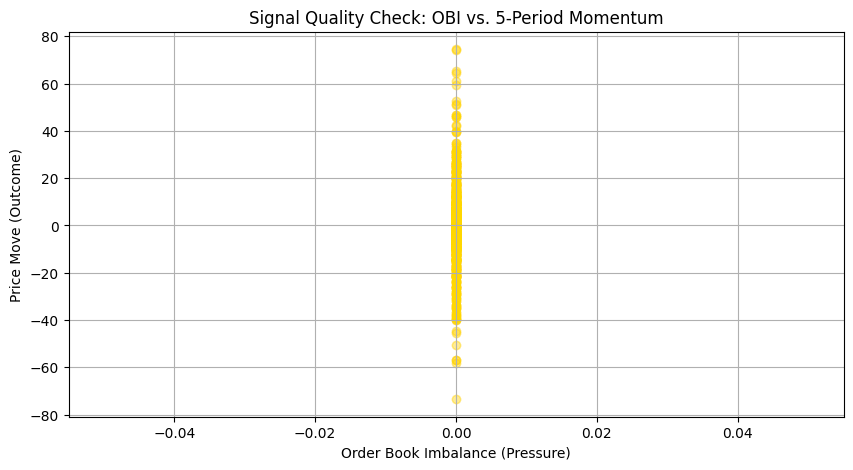

In [60]:
# 1. Load the Overnight "Gold"
DATA_PATH = "data/training/"
df = pd.read_parquet(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['ticker', 'timestamp'])

# 2. Reconstruct Unrealized PnL by Category
# We calculate the delta between current bid and a baseline price (proxy for entry)
# to see which categories showed the most "Alpha" potential.
df['price_delta'] = df.groupby('ticker')['bid'].diff().fillna(0)

category_report = df.groupby('category').agg({
    'price_delta': ['sum', 'mean', 'std'],
    'spread': 'mean',
    'obi': 'mean',
    'ticker': 'nunique'
}).reset_index()

# Flatten columns for readability
category_report.columns = [
    'Category', 'Total_Movement', 'Avg_Move', 
    'Volatility', 'Avg_Spread', 'Avg_OBI', 'Unique_Markets'
]

print("--- OVERNIGHT PERFORMANCE BY CATEGORY ---")
print(category_report.sort_values(by='Total_Movement', ascending=False))

# 3. Visual: OBI vs. Momentum Correlation
# Does a high OBI actually lead to a price move in your data?
plt.figure(figsize=(10, 5))
plt.scatter(df['obi'], df['momentum_5'], alpha=0.1, color='gold')
plt.title("Signal Quality Check: OBI vs. 5-Period Momentum")
plt.xlabel("Order Book Imbalance (Pressure)")
plt.ylabel("Price Move (Outcome)")
plt.grid(True)
plt.show()

In [61]:
import numpy as np
#TFT sequence Validatior
# 1. Load your overnight data
df = pd.read_parquet("data/training/")

# 2. Check for Gaps in time_idx per Ticker
def find_sequence_gaps(group):
    # Sort by time_idx to ensure order
    sorted_idx = group['time_idx'].sort_values().values
    
    # A perfect sequence should have a difference of 1 between every step
    expected_range = np.arange(sorted_idx.min(), sorted_idx.max() + 1)
    missing = np.setdiff1d(expected_range, sorted_idx)
    
    return pd.Series({
        'start': sorted_idx.min(),
        'end': sorted_idx.max(),
        'total_steps': len(sorted_idx),
        'missing_count': len(missing),
        'gaps': missing.tolist()[:5]  # Show first 5 gaps if they exist
    })

# Run the audit grouped by ticker
audit_report = df.groupby('ticker').apply(find_sequence_gaps)

# 3. Final Verdict
total_gaps = audit_report['missing_count'].sum()
if total_gaps == 0:
    print("✅ DATA INTEGRITY VERIFIED: Zero gaps found in time_idx sequences.")
else:
    print(f"⚠️ WARNING: Found {total_gaps} missing steps across your tickers.")
    print(audit_report[audit_report['missing_count'] > 0])

✅ DATA INTEGRITY VERIFIED: Zero gaps found in time_idx sequences.


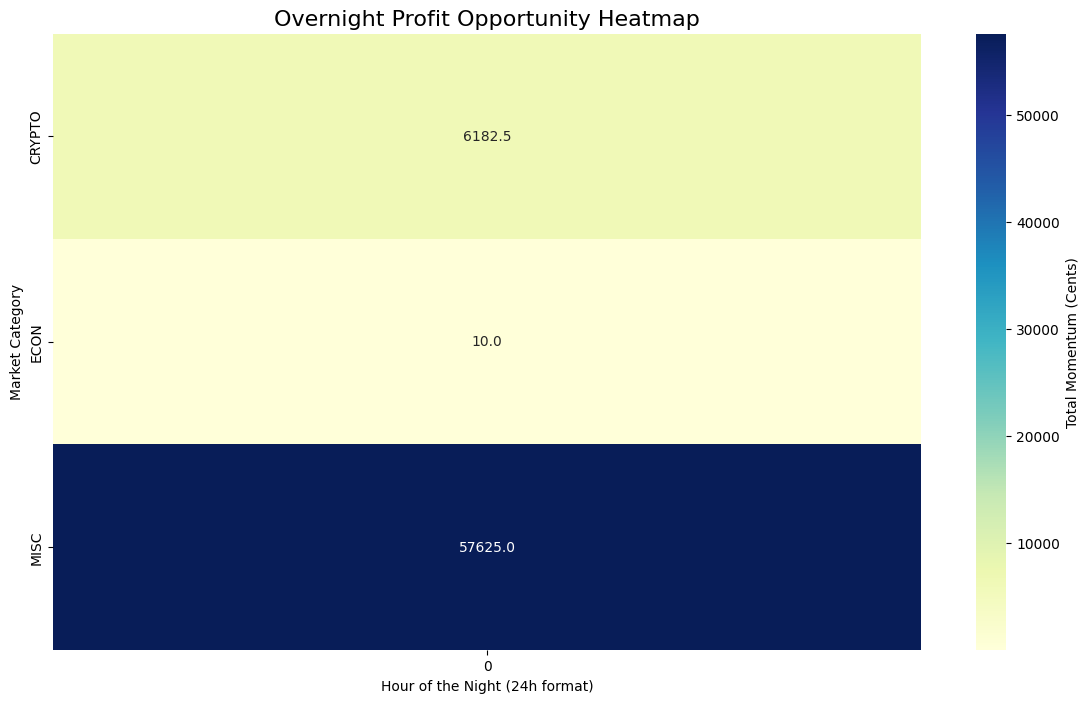

In [62]:
import seaborn as sns


# 1. Load your overnight training data
df = pd.read_parquet("data/training/")

# 2. Fix timestamp and extract the Hour
# Using unit='s' if your M4 records in unix seconds
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['hour'] = df['timestamp'].dt.hour

# 3. Calculate the "Heat" (Cumulative Momentum)
# We aggregate the absolute momentum to find periods of high opportunity
heatmap_data = df.pivot_table(
    index='category', 
    columns='hour', 
    values='momentum_5', 
    aggfunc=lambda x: x.abs().sum()
)

# 4. Generate the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".1f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Total Momentum (Cents)'}
)

plt.title("Overnight Profit Opportunity Heatmap", fontsize=16)
plt.xlabel("Hour of the Night (24h format)")
plt.ylabel("Market Category")
plt.show()

## Correlation Heatmap

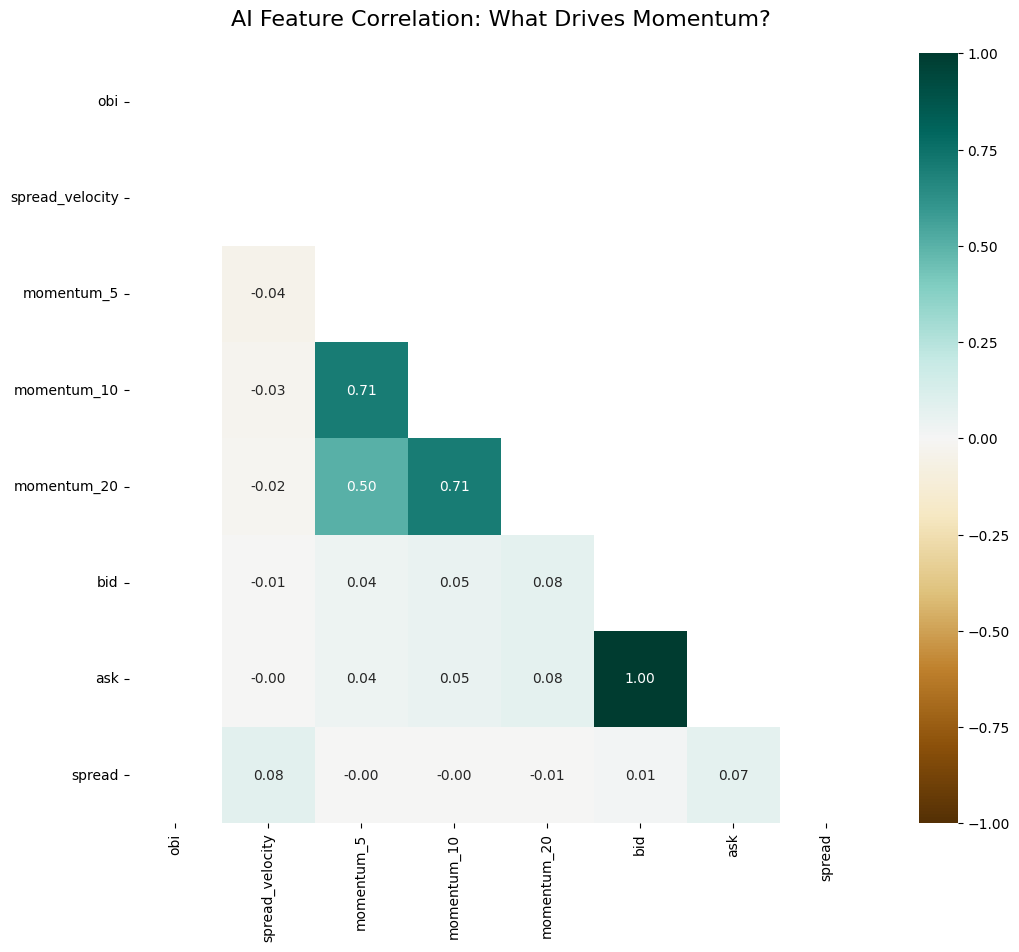

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Gold Set
df = pd.read_parquet("data/training/")

# 2. Select numerical features for the AI brain
# We include OBI, Momentum, and Spread Velocity
features = [
    'obi', 'spread_velocity', 'momentum_5', 
    'momentum_10', 'momentum_20', 'bid', 'ask', 'spread'
]
corr_matrix = df[features].corr()

# 3. Create a Mask for the Upper Triangle
# (Hides duplicate data to make the heatmap easier to read)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 4. Generate the Heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask, 
    vmin=-1, vmax=1, 
    annot=True, 
    cmap='BrBG',
    fmt=".2f"
)

plt.title("AI Feature Correlation: What Drives Momentum?", fontsize=16, pad=20)
plt.show()

## stop loss auditor

In [64]:
import pandas as pd
import numpy as np

def run_stop_loss_audit(path="data/training/"):
    # 1. Load Data
    try:
        df = pd.read_parquet(path)
    except Exception as e:
        print(f"Error loading Parquet: {e}")
        return

    # Fix Timestamp (Convert from Unix Seconds to DateTime)
    if df['timestamp'].dtype == 'float64' or df['timestamp'].dtype == 'int64':
         df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    print(f"Loaded {len(df)} records. Analyzing Equity Drain...")

    # 2. Group by Ticker to find "Entry" vs "Current"
    # We assume the first record is entry and last is current state
    audit = df.groupby('ticker').agg({
        'bid': ['first', 'last', 'min', 'max'],
        'category': 'first',
        'series_ticker': 'first'
    })
    
    # Flatten columns
    audit.columns = ['entry_bid', 'last_bid', 'min_bid', 'max_bid', 'category', 'series_ticker']
    
    # 3. Calculate PnL Stats
    audit['unrealized_pnl'] = audit['last_bid'] - audit['entry_bid']
    audit['max_drawdown'] = audit['min_bid'] - audit['entry_bid']
    
    # 4. Identify "Toxic" Markets (Bleeding > 10 cents)
    toxic = audit[audit['unrealized_pnl'] < -10].sort_values('unrealized_pnl')
    
    # 5. Identify "Winners" (Gains > 5 cents)
    winners = audit[audit['unrealized_pnl'] > 5].sort_values('unrealized_pnl', ascending=False)

    print("\n--- 🩸 TOP 5 EQUITY DRAINERS (Toxic) ---")
    if not toxic.empty:
        print(toxic[['category', 'entry_bid', 'last_bid', 'unrealized_pnl']].head(5))
    else:
        print("✅ No major bleeders found.")

    print("\n--- 🚀 TOP 5 WINNERS ---")
    if not winners.empty:
        print(winners[['category', 'entry_bid', 'last_bid', 'unrealized_pnl']].head(5))
    else:
        print("Waiting for price moves...")

run_stop_loss_audit()

Loaded 915514 records. Analyzing Equity Drain...

--- 🩸 TOP 5 EQUITY DRAINERS (Toxic) ---
                                       category  entry_bid  last_bid  \
ticker                                                                 
KXATPCHALLENGERMATCH-26FEB01JANMEC-MEC     MISC         99        25   
KXCBAGAME-26FEB01QINBED-QIN                MISC         99        34   
KXWTAMATCH-26FEB01RUZYUA-RUZ               MISC         61         2   
KXWTAMATCH-26FEB01SAMKEN-SAM               MISC         96        38   
KXWTAMATCH-26FEB01BANSIS-BAN               MISC         79        22   

                                        unrealized_pnl  
ticker                                                  
KXATPCHALLENGERMATCH-26FEB01JANMEC-MEC             -74  
KXCBAGAME-26FEB01QINBED-QIN                        -65  
KXWTAMATCH-26FEB01RUZYUA-RUZ                       -59  
KXWTAMATCH-26FEB01SAMKEN-SAM                       -58  
KXWTAMATCH-26FEB01BANSIS-BAN                       -57  

--- 🚀

## data optimizer

In [ ]:
def get_optimized_features(path="data/training/"):
    df = pd.read_parquet(path)
    
    # 1. Calculate Variance (How much does the data wiggle?)
    # If variance is 0 (like your current OBI), it's dead data.
    numeric_df = df.select_dtypes(include=[np.number])
    variances = numeric_df.var()
    
    # 2. Define "Dead" features
    dead_features = variances[variances < 0.0001].index.tolist()
    
    # 3. Define "Active" features
    # Exclude IDs and known non-features
    exclude = ['time_idx', 'bid', 'ask', 'spread', 'volume'] 
    active_features = [c for c in numeric_df.columns if c not in dead_features and c not in exclude]
    
    print(f"--- DATASET OPTIMIZER ---")
    print(f"💀 PRUNED (Dead/Flat): {dead_features}")
    print(f"✅ ACTIVE AI FEATURES: {active_features}")
    
    return active_features

# Run it
active_features = get_optimized_features()